Firstly, we import some Devito modules and other packages that will be used in the implementation. Then, we define some useful functions.

In [1]:
# devito
from devito import (Function, TimeFunction, Inc, Eq, Operator, Grid, Operator, VectorTimeFunction, NODE,
                    div, grad, solve, configuration, gaussian_smooth)
from examples.seismic import (AcquisitionGeometry, TimeAxis, Receiver, Model, ModelViscoacoustic, RickerSource,
                              demo_model, setup_geometry, plot_velocity, plot_shotrecord)
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.tti import AnisotropicWaveSolver
from examples.seismic.tti.operators import kernel_centered_2d
from examples.seismic.viscoacoustic.operators import sls_2nd_order
# dask 
import dask
import dask.distributed as dd
# numpy, segyio, matplotlib and others

#from utils import segy_write, make_lookup_table, load_shot
from matplotlib import pyplot as plt
import pickle
import time
import h5py
import json
import sys
import os
import subprocess
import segyio as so
# sotb-wrapper
from sotb_wrapper import interface
import numpy as np
import sympy as sp
import pooch

# from sotb-wrapper import interface


#configuration['log-level'] = 'DEBUG'
words = ['ST', 'CG', 'LB']
lconfg = {'ST': ['Steepest descent', 'x'],
          'CG': ['Nonlinear conjugate gradient', '^'],
          'LB': ['l-BFGS', 's']}

The function below save a numpy array into a HDF5 file

In [2]:
def save_model(model_name, datakey, data, metadata, dtype=np.float32):
    """Write a Numpy Array to a HDF5 file
    Args:
        model_name (str): Name of HDF5 file
        datakey (str): Name for the dataset
        data (np.ndarray): Physical parameter (i.e., vp)
        metadata (dict): Dictionary with header info
        dtype: numpy data type
    """
    # Open HDF5 file and write in the data and info (metadata)
    with h5py.File(model_name, 'w') as f:
        f.create_dataset(datakey, data=data, dtype=dtype)
        f.create_dataset('metadata', data=json.dumps(metadata))

The following function will be used for executing Shell Commands in the next sections

In [3]:
def SafeExtern(mycmd, rundir):
    """Wrapper to call external programs checking the results.
    from https://stackoverflow.com/questions/26741316/how-do-i-\
    run-multiple-executables-in-python-one-after-the-other
    Args:
        mycmd (str): External command to be executed
        rundir (str): Running directory of command
    Returns:
        retcode (int): Returncode from the executed process
    """
    try:  # This allows exceptions to be caught
        retcode = subprocess.call(mycmd, shell=True, cwd=rundir)  # Call ext prog
        if retcode < 0:  # Check the return code errors should be <0
            print(sys.stderr, "Child was terminated by signal", -retcode)
        else:
            print(sys.stderr, "Child returned", retcode)  # For information
    except OSError as e:  # Catch OSErrors and let the user know
        print(sys.stderr, "Execution failed:", e)
        retcode = -1  # Obviously this is an error
    return retcode

This other function performs a reduction operation on numpy arrays

In [4]:
def sum_results(*elements):
    """This function takes in a variable number of input arguments,
    which could be numpy arrays or scalars, and returns the sum of
    these elements along axis 0.
    Args:
        *elements: Variable length argument list of numpy arrays or scalars (0-d arrays).
    Returns:
        A numpy array containing the sum of all input elements along axis 0.
    """
    return np.sum(elements, axis=0)

This function is used to define a list of tasks to be performed in parallel with dask

In [5]:
def create_break_list(tasks_master_list, p):
    """
    creates a list of sublists (break_list) by using a list comprehension
    that iterates over the range from 0 to the number of sublists (p).
    Args: 
        tasks_master_list: list of tasks to be split
        p: number of sublists to break the tasks_master_list into
    Returns:
        break_list: list of sublists. The list contains p sublists, each
        containing a subset of the original tasks_master_list in order
    """
    c = len(tasks_master_list) // p
    r = len(tasks_master_list) % p
    break_list = [
        tasks_master_list[i * (c + 1): i * (c + 1) + c + 1] if i < r else
        tasks_master_list[i * c + r: i * c + r + c]
        for i in range(0, p)
    ]
    return break_list

In [6]:
def segy_write(data, sourceX, sourceZ, groupX, groupZ, dt, filename, sourceY=None, groupY=None,
               elevScalar=-1000, coordScalar=-1000):
    """
    Write seismic data to a SEGY file.

    Args:
        data (numpy.ndarray): A 2D array containing the seismic data to be written.
        sourceX (numpy.ndarray): An array containing the x coordinates of the seismic sources.
        sourceZ (numpy.ndarray): An array containing the z coordinates of the seismic sources.
        groupX (numpy.ndarray): An array containing the x coordinates of the receivers.
        groupZ (numpy.ndarray): An array containing the z coordinates of the receivers.
        dt (float): The time sampling interval of the data in seconds.
        filename (str): The name of the SEGY file to be written.
        sourceY (numpy.ndarray, optional): An array containing the y coordinates of the seismic sources.
            Defaults to None.
        groupY (numpy.ndarray, optional): An array containing the y coordinates of the receivers.
            Defaults to None.
        elevScalar (int, optional): The elevation scalar value. Defaults to -1000.
        coordScalar (int, optional): The coordinate scalar value. Defaults to -1000.
    """
    nt = data.shape[0]
    nxrec = len(groupX)

    if sourceY is None and groupY is None:
        sourceY = np.zeros(1, dtype='int')
        groupY = np.zeros(nxrec, dtype='int')

    # Create spec object
    spec = so.spec()
    spec.ilines = np.arange(nxrec)    # dummy trace count
    spec.xlines = np.zeros(1, dtype='int')  # assume coords are already vectorized for 3D
    spec.samples = range(nt)
    spec.format = 1
    spec.sorting = 1
    with so.create(filename, spec) as segyfile:
        for i in range(nxrec):
            segyfile.bin = {
                so.BinField.Samples: data.shape[0],
                so.BinField.Traces: data.shape[1],
                so.BinField.Interval: int(dt*1e3)
            }
            segyfile.header[i] = {
                so.su.tracl: i+1,
                so.su.tracr: i+1,
                so.su.fldr: 1,
                so.su.tracf: i+1,
                so.su.sx: int(np.round(sourceX[0] * np.abs(coordScalar))),
                so.su.sy: int(np.round(sourceY[0] * np.abs(coordScalar))),
                so.su.selev: int(np.round(sourceZ[0] * np.abs(elevScalar))),
                so.su.gx: int(np.round(groupX[i] * np.abs(coordScalar))),
                so.su.gy: int(np.round(groupY[i] * np.abs(coordScalar))),
                so.su.gelev: int(np.round(groupZ[i] * np.abs(elevScalar))),
                so.su.dt: int(dt*1e3),
                so.su.scalel: int(elevScalar),
                so.su.scalco: int(coordScalar)
            }
            segyfile.trace[i] = data[:, i]
        segyfile.dt = int(dt*1e3)


def make_lookup_table(sgy_file):
    """
    Make a lookup of shots, where the keys are the shot record IDs being searched (looked up)

    Args:
        sgy_file (str): The name of the SEGY file to be used for the lookup table.

    Returns:
        tbl (dict): A dictionary containing the shot record IDs as keys
    """
    tbl = {}
    with so.open(sgy_file, ignore_geometry=True) as f:
        f.mmap()
        idx = None
        pos_in_file = 0
        for hdr in f.header:
            if int(hdr[so.TraceField.SourceGroupScalar]) < 0:
                scalco = abs(1./hdr[so.TraceField.SourceGroupScalar])
            else:
                scalco = hdr[so.TraceField.SourceGroupScalar]
            if int(hdr[so.TraceField.ElevationScalar]) < 0:
                scalel = abs(1./hdr[so.TraceField.ElevationScalar])
            else:
                scalel = hdr[so.TraceField.ElevationScalar]
            # Check to see if we're in a new shot
            if idx != hdr[so.TraceField.FieldRecord]:
                idx = hdr[so.TraceField.FieldRecord]
                tbl[idx] = {}
                tbl[idx]['filename'] = sgy_file
                tbl[idx]['Trace_Position'] = pos_in_file
                tbl[idx]['Num_Traces'] = 1
                tbl[idx]['Source'] = (hdr[so.TraceField.SourceX]*scalco,
                                      hdr[so.TraceField.SourceY]*scalco,
                                      hdr[so.TraceField.SourceSurfaceElevation] *
                                      scalel)
                tbl[idx]['Receivers'] = []
            else:  # Not in a new shot, so increase the number of traces in the shot by 1
                tbl[idx]['Num_Traces'] += 1
            tbl[idx]['Receivers'].append((hdr[so.TraceField.GroupX]*scalco,
                                         hdr[so.TraceField.GroupY]*scalco,
                                         hdr[so.TraceField.ReceiverGroupElevation] *
                                         scalel))
            pos_in_file += 1

    return tbl


def load_shot(filename, position, traces_in_shot):
    """Loads a shot from a SEGY file and returns the shot data, 
    maximum time and time interval.

    Args:
        filename (str): Name of the SEGY file containing the shot data.
        position (int): Position of the first trace of the shot in the file.
        traces_in_shot (int): Number of traces in the shot.

    Returns:
        tuple: A tuple containing:
            - retrieved_shot (ndarray): A 2D NumPy array with the shot data. Each column
              corresponds to a trace and each row to a time sample.
            - tmax (float): Maximum time in the shot.
            - samp_int (float): Time interval between samples in the shot.
    """
    f = so.open(filename, ignore_geometry=True)
    num_samples = len(f.samples)
    samp_int = f.bin[so.BinField.Interval]/1000.
    retrieved_shot = np.zeros((num_samples, traces_in_shot))
    shot_traces = f.trace[position:position+traces_in_shot]
    for i, trace in enumerate(shot_traces):
        retrieved_shot[:, i] = trace

    tmax = (num_samples-1)*samp_int

    return retrieved_shot, tmax, samp_int

Finally, these two will help in the making of the figures of the convergence and computational cost curves

In [7]:
def read_log_files(words):
    """
    Reads log files for each word (optimization method abreviation) in the given list and 
    returns specific fields from the log files.
    Args:
        words (list): A list of strings representing the words in the log file names, e.g. ['ST', 'CG', 'LB'].
    Returns:
        tuple: A tuple containing two dictionaries. The first dictionary maps each word to a list of data
            points extracted from its corresponding log file. The second dictionary maps each word to a 
            list of secondary data points extracted from the same log file.
    """
    d = {}
    d2 = {}
    for word in words:
        try:
            with open(f'iterate_{word}.dat', 'r') as f:
                lines = f.readlines()[9:-3]
                data = [float(line.split()[3]) for line in lines]
                d[word] = data
                d2[word] = [float(line.split()[-1]) for line in lines]
        except FileNotFoundError:
            print(f"WARNING: Log file 'iterate_{word}.dat' not found.")
            continue
    if d == {}:
        sys.exit('There are no Log files, '
                 'are you sure you have executed an inversion workflow?')
    return d, d2


def make_a_plot(d, d2, lconfg, plot=True):
    """
    Plot convergence and computational cost curves.
    Args:
        d (Dict): Dictionary with information about the normalized error for each key.
        d2 (Dict): Dictionary with information about the number of computed gradients for each key.
        lconfg (Dict): Dictionary with information for the legend and symbol for Matplotlib.
        plot (bool, optional): Whether to display the plot or save it as a file. Default is True.
    Returns:
        None
    """
    plt.subplots(figsize=(15, 5))
    plt.clf()
    plt.subplot(1, 2, 1)  # draw plot 1
    for k, v in d.items():
        plt.plot(v, fillstyle='none', linestyle='-', marker=lconfg[k][1],
                 markersize=5, linewidth=1, label=lconfg[k][0])
    plt.xlabel('Iterations')
    plt.ylabel('Relative objective function (log scale)')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle=':', linewidth=0.5)
    plt.legend(loc='upper right', frameon=True, prop={'size': 10})
    #
    plt.subplot(1, 2, 2)  # draw plot 2
    for (k, v), (k2, v2) in zip(d.items(), d2.items()):
        plt.plot(v2, v, fillstyle='none', linestyle='-', marker=lconfg[k][1],
                 markersize=5, linewidth=1, label=lconfg[k][0])
    plt.xlabel('Computed gradients')
    plt.ylabel('Relative objective function (logscale)')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle=':', linewidth=0.5)
    plt.legend(loc='upper right', frameon=True, prop={'size': 10})
    plt.show() if plot else plt.savefig('convergence-cost_curves.pdf')

## Get the Marmousi model and store locally
### Download tar file from AWS

We do not provide you with the velocity file here, but the data can be be easily downloaded running the follow cell

In [8]:
# NBVAL_IGNORE_OUTPUT
tar_file_name = pooch.retrieve(
    url="https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz",
    known_hash="b6fe8d10ce6a6dfadf203a8d0e1a040ce9f2c6cb52c1366193d35113d61797fe",
#     progressbar=True,
)
print(tar_file_name)

/home/atila/.cache/pooch/0fa62e93ed86dba35818f58fb91de222-elastic-marmousi-model.tar.gz


### Only Extract Velocity File from tar.gz file

Let's take a quick look at the contents of the tar.gz file without actually extracting it.

In [9]:
# NBVAL_IGNORE_OUTPUT
exe = "tar -tf"
cmd = " ".join((exe, tar_file_name))

SafeExtern(cmd, "./")

elastic-marmousi-model/model/
elastic-marmousi-model/processed_data/SEGY-Time/Kirchhoff_PoSTM_time.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Time/SYNTHETIC_time.segy.tar.gz
elastic-marmousi-model/model/LAYER_PROPERTIES.pdf
elastic-marmousi-model/processed_data/SEGY-Depth/SYNTHETIC.segy.tar.gz
elastic-marmousi-model/processed_data/
elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PreSDM.segy.tar.gz
elastic-marmousi-model/model/FINAL_HORIZONS.asc
elastic-marmousi-model/model/FINAL_HORIZONS_GX2.asc
elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PoSDM.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Time/NMOstack_SRME_time.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/Vs.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/NMOstack.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/WE_PreSDM.segy.tar.gz
elastic-marmousi-model/reports/
elastic-marmousi-model/processed_data/SEGY-Time/
elastic-marmousi-model/model/MODEL

0

Now, extract the file that interests us

In [10]:
# NBVAL_IGNORE_OUTPUT
exe = "tar -xvf"
fname = "elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz"
cmd = " ".join((exe, tar_file_name, fname))

SafeExtern(cmd, "./")

elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy.tar.gz
<ipykernel.iostream.OutStream object at 0x7fee4932ae80> Child returned 0


0

The extracted file is also compressed. Extract this new .tar.gz archive to elastic-marmousi-model/model directory

In [11]:
# NBVAL_IGNORE_OUTPUT

cmd = " ".join((exe, fname, "-C", fname.rsplit('/',1)[0]))

SafeExtern(cmd, "./")

MODEL_P-WAVE_VELOCITY_1.25m.segy
<ipykernel.iostream.OutStream object at 0x7fee4932ae80> Child returned 0


0

### Extract the acoustic velocity from the .segy file

After reading the file, we get some of the basic attributes of the file

In [12]:
# code below was borrowed from 
# https://github.com/equinor/segyio-notebooks/blob/master/notebooks/basic/03_basic_segy_editing.ipynb
with so.open(fname[:-7], ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = so.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 13601, N Samples: 2801, Sample rate: 1.25ms, Trace length: 3500.0'

The velocity file has a grid interval of 1.25m and a depth of 3500 meters. We want to downsample the model reducing its size by a factor of 32 in each dimension for easier processing (grid interval at 40m). This should result in a 88x426 model.

In [13]:
# Use NumPy array slicing to create a new array vp from the existing data array
vp = data[::32, ::32] # selects every 32nd element in both dimensions of the data array

# creates a boolean mask of the same shape as `vp`, where True values represent the water layer
mask = np.where((vp == 1500.), True, False)

# scaling is needed to convert the data to km/sec
vp *= 0.001

# Define some tuples with info about vp array
origin = (0., 0.) # starting point or reference point of the grid
shape = vp.shape # shape of the vp array that was defined earlier
spacing = (40., 40.) # spacing between grid points in meters

# Create a dictionary called metadata to keep track of important information about the vp array,
# such as its dimensions, origin, and spacing
metadata = {'origin' : origin,
            'shape' : shape,
            'spacing' : spacing,}
print(metadata)

{'origin': (0.0, 0.0), 'shape': (426, 88), 'spacing': (40.0, 40.0)}


### Smooth the vp array to generate true and initial models

Note that we will perform this FWI example at low frequency, and so we smooth both the true and the initial models before we begin.

In [14]:
# NBVAL_IGNORE_OUTPUT

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing
#layer as 50 grid points
qp = np.zeros(shape)
rho = np.zeros(shape)

qp[:] = 3.516*((vp[:]*1000.)**2.2)*10**(-6) # Li's empirical formula

rho[:] = 0.31*(vp[:]*1000.)**0.25 # Gardner's relation

model = ModelViscoacoustic(vp=vp, origin=origin, qp=qp, b=1/rho, shape=shape, spacing=spacing,
              space_order=4, nbl=50)

# plot_velocity(model)

Operator `initdamp` ran in 0.01 s


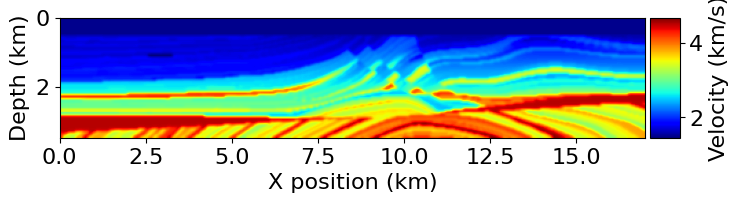

In [15]:
# NBVAL_IGNORE_OUTPUT

# creates new copies of the `vp` array.
v1 = np.copy(vp)
v2 = np.copy(vp)

# create a set of slices that can be used to extract the "valid" portion of a velocity array, 
# i.e., the portion of the array that does not include the padding layers
slices = tuple(slice(model.nbl, -model.nbl) for _ in range(len(shape)))

# apply a Gaussian Filter to smooth slightly the v1 array
# use the gaussian_smooth utility from devito
gaussian_smooth(v1, sigma=(1, 1))

# performs element-wise assignment on the array `v1`,
# replacing the values in the locations where the `mask` is True with the scalar value 1.5.
v1[mask] = 1.5

# update `vp` in model with `v1`array
model.update('vp', v1)
plot_velocity(model)
# Save true model along its metadata in hdf5 file
save_model('vp.h5', 'vp', model.vp.data[slices], metadata, dtype=np.float32)

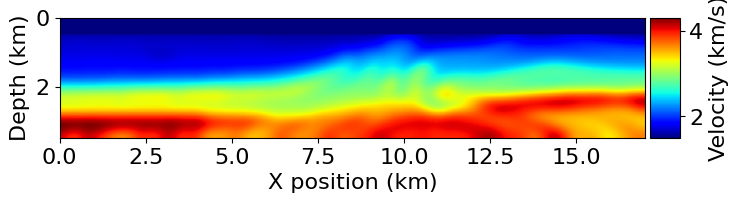

In [16]:
# NBVAL_IGNORE_OUTPUT

# Perform the same steps above, but using `v2`array

# apply a Gaussian filter to reduce the high frequency components of `v2`
# the smoothing here is much greater
gaussian_smooth(v2, sigma=(5, 5))

# sets all elements in `v1` that correspond to True values in the boolean mask
# array `mask` to the scalar value 1.5.
v2[mask] = 1.5

# # update `vp` in model with `v2`array
model.update('vp', v2)
plot_velocity(model)
# Save start model along its metadata in hdf5 file
save_model('vp_start.h5', 'vp', model.vp.data[slices], metadata, dtype=np.float32)

### Forward modeling

Before inversion, we need to check for cycle skipping. We define a class `FwdClass` that takes several arguments to set some attributes and defines a callable method `__call__` which performs the forward modeling. This method will be called when an instance of `FwdClass` is called like a function. The class constructor takes an instance of the `AcquisitionGeometry` class as its first argument, which should contain all the necessary information for the simulation. The `dtrec` argument sets the time sampling rate for the recorded data, while `save_shot` and `nworkers` control whether to save the entire shot and how many parallel workers to use, respectively. It sets several instance variables based on the input arguments, including the source and receiver arrays, time step, start and end times, and a `TimeFunction` object for the pressure field.

In [17]:
class FwdClass:
    """Compute the forward modeling."""

    def __init__(self, geometry, dtrec=None, save_shot=False, nworkers=4):
        """
        Constructor for FwdClass instances.

        Args:
            geometry (examples.seismic.utils.AcquisitionGeometry): instance of the AcquisitionGeometry
                class. The geometry to use for the simulation. The geometry allows to set the
                source, receiver, time step, start time, end time, and computational grid.
            dtrec (float or None, optional):
                The time sampling rate for the recorded data. If None, the time step in
                the provided geometry will be used. Default is None.

            save_shot (bool, optional):
                Whether to save the entire shot to segy file. Default is False.

            nworkers (int, optional):
                The number of dask workers to use for the simulation. Default is 4.

        Returns:
            None
        """
        self.src = geometry.src
        self.rec = geometry.rec
        self.dt = geometry.dt
        self.t0 = geometry.t0
        self.tn = geometry.tn
        self.dtrec = dtrec
        self.save_shot = save_shot
        self.nworkers = nworkers
        self.v = TimeFunction(name="v", grid=geometry.grid,
            time_order=2, space_order=4, staggered=NODE)
        self.r = TimeFunction(name="r", grid=geometry.grid, time_order=1, 
            space_order=4, staggered=NODE)

    def __call__(self, fcn_list):
        """
        Perform a forward simulation for a list of input source locations.

        Args:
            fcn_list (list): list of numpy arrays
                A list of input source locations, where each element is a numpy array of shape
                (1, ndim), with ndim being the number of spatial dimensions.

        Returns:
            bool or list of numpy arrays
                If `save_shot` is True, the method returns True after saving the shot data to
                disk. Otherwise, it returns a list of numpy arrays containing the recorded
                data for each input source location.
        """
        with open('op.pickle', 'rb') as handle:
            op = pickle.load(handle)
        with open('model.pickle', 'rb') as handle:
            model = pickle.load(handle)
        shots =[]
        for i, d in enumerate(fcn_list):
            dt = self.dt
            self.v.data[:] = 0.
#             self.r.data[:] = 0.
            self.src.coordinates.data[:] = d[:]
#             op(vp=model.vp, src=self.src, rec=self.rec, p=self.v, dt=self.dt)
            op(vp=model.vp, src=self.src, rec=self.rec, p=self.v, r=self.r, dt=self.dt)

            if self.dtrec is not None:
                dt = self.dtrec
                nsamples = int((self.tn-self.t0)/self.dtrec + 1)
                newrec = self.rec.resample(num=nsamples)
                if self.save_shot:
                    # Save shot in segy format
                    str_id = str((dd.get_worker().name * self.nworkers) + i).zfill(3)
                    fname = '{}_{}_suheader.segy'.format('shot', str_id)
                    segy_write(newrec.data[:], [self.src.coordinates.data[0, 0]],
                               [self.src.coordinates.data[0, -1]],
                               newrec.coordinates.data[:, 0],
                               newrec.coordinates.data[:, -1], dt, fname)
                else:
                    shots.append(np.copy(newrec.data[:]))
            else:
                if self.save_shot:
                    # Save shot in segy format
                    str_id = str((dd.get_worker().name * self.nworkers) + i).zfill(3)
                    fname = '{}_{}_suheader.segy'.format('shot', str_id)
                    segy_write(self.rec.data[:], [self.src.coordinates.data[0, 0]],
                               [self.src.coordinates.data[0, -1]],
                               self.rec.coordinates.data[:, 0],
                               self.rec.coordinates.data[:, -1], dt, fname)
                else:
                    shots.append(np.copy(self.rec.data[:]))                

        return True if self.save_shot else shots

Read the true model saved before and create a new `model` object. Then create a `geometry` object with `setup_geometry` function.  This function takes a `model` as input, along with the maximum simulation time (ms) and peak frequency (KHz) parameters to perform source and receivers coordinates calculations based on attributes of the model. It returns the geometry of an acquisition for a single shot. Our simulation lasts 5000.0 ms and uses a Ricker wavelet source with peak frequency of 0.004 KHz

In [18]:
# NBVAL_IGNORE_OUTPUT

# Read vp and metadata from hdf5 file
with h5py.File('./vp.h5', 'r') as f:
    metadata = json.loads(f['metadata'][()])
    #
    origin = (*metadata['origin'],)
    shape = (*metadata['shape'],)
    spacing = (*metadata['spacing'],)
    #
    vp = np.empty(shape)
    vp[:] = f['vp'][()]

qp = np.zeros(shape)
rho = np.zeros(shape)

qp[:] = 3.516*((vp[:]*1000.)**2.2)*10**(-6) # Li's empirical formula

rho[:] = 0.31*(vp[:]*1000.)**0.25 # Gardner's relation
# create a new model object from `vp`
model = ModelViscoacoustic(vp=vp, origin=origin, qp=qp, b=1/rho, shape=shape, spacing=spacing,
              space_order=4, nbl=50)
# Create a geometry with tn=5000. ms and f0=0.004 KHz
tn=5000.
geometry = setup_geometry(model, tn, f0=0.004)

Operator `initdamp` ran in 0.01 s


The `critical_dt` property can be used to obtain the maximum allowable time step value

In [19]:
model.critical_dt

4.76

To make things easier, we will use a `dt` of 2 ms. We use the `resample` method to manually set the time step value for the simulation. The method sets the `_dt` attribute of the `AcquistionGeometry` instance to the value of `dt` passed as a parameter. The `_dt` attribute is used by other methods of the class. 

Overall, the purpose of this step is to allow easy creation of a `Receiver` and `PointSource` objects with the appropriate properties based on the attributes of the current class instance. It is done via the `rec`ans `src` properties. 

In [20]:
geometry.resample(dt=2.)
print(geometry.rec.coordinates.shape)

(426, 2)


Now, we create a Devito operator as in tutorial_01. Note that when the `rec` property is accessed, it calls the `new_rec` method to create a new instance of a `Receiver` class. The `rec` property provides a shorthand for creating a new receiver object by calling the `new_rec` method. The same concept of creating a shorthand for creating a new object is used in the `src` property (it calls the `new_src` method to create a new instance of a `PointSource` class)

In [21]:
dt = geometry.dt
time_range = TimeAxis(start=0., stop=tn, step=dt)
print(time_range.num-1)
p = TimeFunction(name="p", grid=model.grid, time_order=2, space_order=4, staggered=NODE)
# # Attenuation Memory variable
r = TimeFunction(name="r", grid=model.grid, time_order=1, space_order=4, staggered=NODE)

b = model.b
m = model.m
damp = model.damp
qp = model.qp
f0 = geometry._f0
# The stress relaxation parameter
t_s = (sp.sqrt(1.+1./qp**2)-1./qp)/f0

# The strain relaxation parameter
t_ep = 1./(f0**2*t_s)

# The relaxation time
tt = (t_ep/t_s)-1.

# Density
rho = 1. / b

pde_r = r.dt - (tt / t_s) * rho * div(b * grad(p, shift=.5), shift=-.5) +  (1. / t_s) * r
u_r = Eq(r.forward, damp * solve(pde_r, r.forward))

# Pressure
pde_p = m * p.dt2 - rho * (1. + tt) * div(b * grad(p, shift=.5), shift=-.5) + r.forward + (1 - damp) * p.dt
u_p = Eq(p.forward, damp * solve(pde_p, p.forward))

src = geometry.src
rec = geometry.rec

src_term = src.inject(field=p.forward, expr=(src * dt**2 / model.m))
rec_term = rec.interpolate(expr=p)

op = Operator([u_r, u_p] + src_term + rec_term, subs=model.spacing_map,  name='Forward')


2500


Below, we use Python's built-in `pickle` module to serialize and save two objects, `op` and `model`, to binary files named 'op.pickle' and 'model.pickle', respectively. These files can later be read and deserialized using the `pickle.load()` function.

In [22]:
with open('op.pickle', 'wb') as handle:
    pickle.dump(op, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Initializes a list of tasks `tasks_master_list` for the modeling problem. In the experiment we will use 16 shots, with the shots locations evenly distributed across the top of the domain. Each item in the list is a numpy array of shape (1, 2). The first coordinate of each array is set to 40 (m), and the second coordinate is set to the x-coordinate (m) of the corresponding shot location.

In [23]:
nshots = 16 # We use 16 shot locations evenly distributed across the top of the model
x = np.linspace(0, model.domain_size[0], num=nshots)
tasks_master_list = [np.full((1, model.dim), [xi, 40.]) for xi in x]
# print(tasks_master_list)

Divide the list of tasks into `p` sub-lists using a `break_list`.

In [24]:
works = 16 # number of dask workers
break_list = create_break_list(tasks_master_list, works)
# print(break_list)

#### Dask to parallelize a function across a cluster of workers

It is time to use Dask to perform parallel computations. The ideia is to use Dask to parallelize the execution of a function, `my_function`, that applies a user-defined function `my_object` to a list of input values `fcn_list`.

In [25]:
def my_function(fcn_list, my_object):
    return my_object(fcn_list)

Create a `LocalCluster` object with 4 workers and connect a `Client` object to the cluster, using the `Client(cluster)` constructor. The `Client` object is used to submit computations to the cluster and retrieve the results.

In [26]:
# Create a LocalCluster and a Client
cluster = dd.LocalCluster(n_workers=works, threads_per_worker=1,
                          memory_limit='4GB', death_timeout=60,
                          resources={'process': 1})
client = dd.Client(cluster)

Create an instance of the `FwdClass` class, and scatters the instance to the Dask cluster using the `client.scatter` method. Scattering an object to the cluster makes a copy of the object and distributes it to the workers in the cluster. Use the `client.map` method to apply the `my_function` function to each sublist of `break_list`, using the scattered `fwd_object` instance as an argument. The `client.map` method distributes the computation across the workers in the cluster and returns a list of futures.

In [27]:
# Create an instance of FwdClass
fwd_object = FwdClass(geometry, nworkers=works)

# Use client.submit to send the object to the worker nodes
fwd_object_future = client.scatter(fwd_object)

# Use client.map to apply the function my_function to each element in the break_list list,
# using p worker processes
results = client.map(my_function, break_list, [fwd_object_future]*works)

Use the `client.gather` method to retrieve the results of the computation from the futures returned by `client.map`. The `client.gather` method collects the results from all the workers in the cluster and returns a list of results.

In [28]:
# NBVAL_IGNORE_OUTPUT

# Get the results
# Use a list comprehension to flatten the resulting list of lists into a single list.
results = [item for sublist in client.gather(results) for item in sublist]

Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 3.72 s
Operator `Forward` ran in 3.61 s
Operator `Forward` ran in 3.61 s
Operator `Forward` ran in 3.73 s
Operator `Forward` ran in 4.07 s
Operator `Forward` ran in 4.02 s
Operator `Forward` ran in 4.09 s
Operator `Forward` ran in 4.06 s
Operator `Forward` ran in 3.82 s
Operator `Forward` ran in 3.68 s
Operator `Forward` ran in 3.81 s
Operator `Forward` ran in 3.01 s
Operator `Forward` ran in 2.91 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 1.73 s


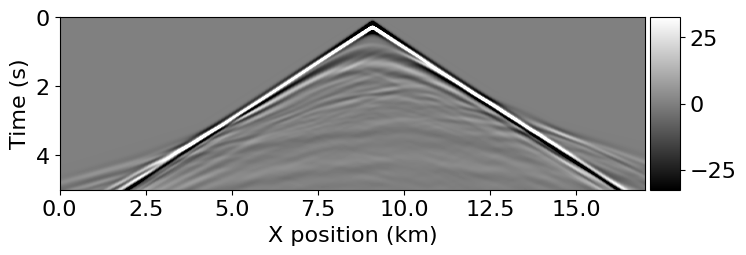

In [29]:
plot_shotrecord(results[8].data, model, 0, tn)

Read the initial velocity from `vp_start.h5` file. The `vp` array is read from the file using the h5py library and assigned to a numpy array called `vp_start`, which is used to update the vp attribute of the `model` object via the `update()` method. Finally, serialize the `model` object to a binary file.

In [30]:
# Read vp_start and metadata from hdf5 file
with h5py.File('./vp_start.h5', 'r') as f:
    metadata = json.loads(f['metadata'][()])
    #
    origin = (*metadata['origin'],)
    shape = (*metadata['shape'],)
    spacing = (*metadata['spacing'],)
    #
    vp_start = np.empty(shape)
    vp_start[:] = f['vp'][()]

model.update('vp', vp_start)

with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# NBVAL_IGNORE_OUTPUT

# Use client.map to apply the function my_function to each element in the break_list list,
# using p worker processes
results2 = client.map(my_function, break_list, [fwd_object_future]*works)

# Get the results
results2 = [item for sublist in client.gather(results2) for item in sublist]

Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.53 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.56 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.43 s


In [32]:
# plot_shotrecord(results2[15].data, model, 0, tn)

Evaluate whether data is cycled skipped at the farthest offsets. To accomplish this, we generate plots of the far offset traces for three shots.

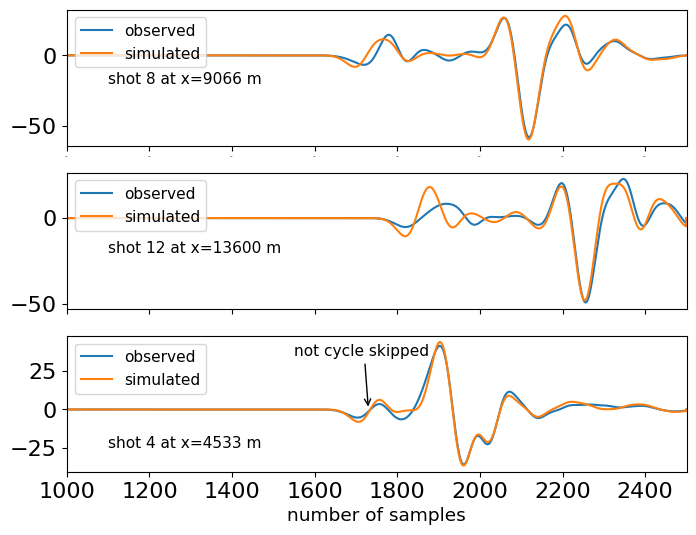

In [33]:
# NBVAL_IGNORE_OUTPUT

ax1 = plt.subplot(311)
plt.plot(results[8][:,-50], label="observed")
plt.plot(results2[8][:,-50], label="simulated")
plt.tick_params('x', labelsize=False)
plt.text(1100., -20.,'shot 8 at x=9066 m', fontsize="x-small")
plt.legend(loc='upper left', fontsize='x-small')

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(results[12][:,180], label="observed")
plt.plot(results2[12][:,180], label="simulated")
# make these tick labels invisible
plt.tick_params('x', labelbottom=False)
plt.text(1100., -20.,'shot 12 at x=13600 m', fontsize="x-small")
plt.legend(loc='upper left', fontsize='x-small')

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(results[4][:,250], label="observed")
plt.plot(results2[4][:,250], label="simulated")
plt.legend(loc='upper left', fontsize='x-small')
plt.text(1100., -25.,'shot 4 at x=4533 m', fontsize="x-small")
plt.xlabel('number of samples', fontsize="small")
plt.annotate('not cycle skipped ', xy=(1730, 0), xytext=(1550, 35),
             fontsize="x-small", arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.xlim(1000, 2501)
plt.show()

Upon examining the plots, we can observe that the refraction waveforms (first arrivals) are not cycle skipped in relation to the true model. Therefore, we can proceed with confidence.

#### Save true data to segy files

Once we have verified that we do not have cycle skipping problems, we proceed with the inversion. We update `vp` attribute of `model` object once more time and then save it into a binary file named 'model.pickle' as before. Then, create a new instance of the `FwdClass` class, setting `save_shot` attribute to `True` and distribute the computation across multiple workers in the Dask cluster.

In [34]:
# NBVAL_IGNORE_OUTPUT

model.update('vp', vp)

with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)


fwd_object = FwdClass(geometry, save_shot=True, nworkers=works)
fwd_object_future = client.scatter(fwd_object)
booleans = client.map(my_function, break_list, [fwd_object_future]*works)

# Get the results
if all(client.gather(booleans)):
    print("Successfully generated {0:d} shots".format(nshots))

Operator `Forward` ran in 2.34 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
Operator `Forward` ran in 2.27 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.29 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
Operator `Forward` ran in 2.41 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warni

Successfully generated 16 shots


Operator `Forward` ran in 1.43 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)


### Inversion

Define a function for generating a Devito operator that computes the gradient and source illumination

In [35]:
def ImagingOperator(geometry, model, image, src_illum, space_order,
                    setup_func, save=True):
    '''
    Creates an adjoint + crosscorrelation Operator. It is used to
    compute the gradient in the functions set out above.

    Args:
        geometry (examples.seismic.utils.AcquisitionGeometry): object that encapsules
            the geometry of an acquisition
        model (examples.seismic.model.SeismicModel): object that encapsules all
            physical parameters
        image (devito.types.Function): Image function
        src_illum (devito.types.Function): Source illumination function
        space_order (int): Discretisation order for space derivatives
        setup_func (str): Type of physical model. Options are 'tti' and 'acoustic'
        save (bool, optional): Whether or not all forward states for all times
            must be saved. Default True

    Returns:
        devito.operator.operator.Operator: adjoint + crosscorrelation Operator
    '''
    dt =geometry.dt
    time_order = 2

    rec = Receiver(name='rec', grid=model.grid, time_range=geometry.time_axis,
                   npoint=geometry.nrec)

    # Gradient symbol and wavefield symbols
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt if save
                     else None, time_order=time_order, space_order=space_order, staggered=NODE)
    du = TimeFunction(name="du", grid=model.grid, save=None,
                      time_order=time_order, space_order=space_order, staggered=NODE)
    # Define the wave equation, but with a negated damping term
    eqn = sls_2nd_order(model, geometry, du, forward=False)

    # Define residual injection at the location of the forward receivers
    res_term = rec.inject(field=du.backward, expr=rec * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Inc(image, - u.dt2 * du)
    src_illum_updt = Eq(src_illum, src_illum + u**2)

    return Operator(eqn + res_term + [image_update] +
                        [src_illum_updt], name='Gradient', subs=model.spacing_map)

Also, create a new Devito operator for forward modeling. This time using a `TimeFunction` with `geometry.nt` buffers for its definition.

In [36]:
# NBVAL_IGNORE_OUTPUT

dt = geometry.dt
p = TimeFunction(name="p", grid=model.grid, time_order=2, space_order=4, save=geometry.nt, staggered=NODE)
b = model.b
m = model.m
damp = model.damp
qp = model.qp
f0 = geometry._f0

# The stress relaxation parameter
t_s = (sp.sqrt(1.+1./qp**2)-1./qp)/f0

# The strain relaxation parameter
t_ep = 1./(f0**2*t_s)

# The relaxation time
tt = (t_ep/t_s)-1.

# Density
rho = 1. / b

    # Attenuation Memory variable
r = TimeFunction(name="r", grid=model.grid, time_order=2, space_order=4, staggered=NODE)


pde_r = r.dt - (tt / t_s) * rho * div(b * grad(p, shift=.5), shift=-.5) + \
            (1. / t_s) * r
u_r = Eq(r.forward, damp * solve(pde_r, r.forward))

# Pressure
pde_p = m * p.dt2 - rho * (1. + tt) * div(b * grad(p, shift=.5), shift=-.5) + \
        r.forward  + (1 - damp) * p.dt
u_p = Eq(p.forward, damp * solve(pde_p, p.forward))


src = geometry.src
rec = geometry.rec
print(src.data.shape)
src_term = src.inject(field=p.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=p.forward)

op_fwd = Operator([u_r, u_p] + src_term + rec_term, subs=model.spacing_map, name='Forward')
op_fwd.cfunction


(2501, 1)


Create `src_illum`and `grad` symbols and instantiate the previously defined imaging operator

In [37]:
# NBVAL_IGNORE_OUTPUT

src_illum = Function(name='src_illum', grid=model.grid)
grad = Function(name='grad', grid=model.grid)

op_grd = ImagingOperator(geometry, model, grad, src_illum, 4, setup_func="viscoacoustic")
op_grd.cfunction

Create a Devito operator to apply the illumination compensation

In [38]:
# NBVAL_IGNORE_OUTPUT

eps = np.finfo(np.float32).eps
eq = Eq(src_illum, grad/(src_illum+eps))
op_ptw = Operator(eq, name="Pointwise")
op_ptw.cfunction

Use the pickle module to dump (i.e., serialize) the objects `op_fwd`, `op_grd`, and `op_ptw` into three separate pickle files named "op_fwd.pickle", "op_grd.pickle", and "op_ptw.pickle", respectively.

In [39]:
with open('op_fwd.pickle', 'wb') as handle:
    pickle.dump(op_fwd, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('op_grd.pickle', 'wb') as handle:
    pickle.dump(op_grd, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('op_ptw.pickle', 'wb') as handle:
    pickle.dump(op_ptw, handle, protocol=pickle.HIGHEST_PROTOCOL)

Define a class `GrdClass` that has an initializer method and a `__call__` method. This method updates the model, calculates the residual between the observed and computed data, calculates the objective function, computes the gradient, applies preconditioning to the gradient, and returns the objective and sum of gradients.

In [40]:
class GrdClass:
    """Compute the gradient of the objective function."""

    def __init__(self, geometry, save=True):
        """
        Initialize the GrdClass object.

        Args:
            geometry (examples.seismic.utils.AcquisitionGeometry): An instance of the AcquisitionGeometry
                class containing information about the seismic survey.
            save (bool, optional): Whether or not to save computed wavefields.
                Defaults to True.

        Returns:
            None
        """
        self.src = geometry.src
        self.rec = geometry.rec
        self.dt = geometry.dt
        self.t0 = geometry.t0
        self.tn = geometry.tn
        self.u0 = TimeFunction(name='u0', grid=geometry.grid, save=geometry.nt if save
                               else None, time_order=2, space_order=4, staggered=NODE)
        self.du = TimeFunction(name="du", grid=geometry.grid, save=None,
                               time_order=2, space_order=4, staggered=NODE)
        self.residual = Receiver(name='residual', grid=geometry.grid,
                                 time_range=geometry.time_axis,
                                 coordinates=self.rec.coordinates)
        self.pg = Function(name='pg', grid=geometry.grid)
        self.g = Function(name='g', grid=geometry.grid)
        self.sumg = Function(name='sumg', grid=geometry.grid)
        
        with open('op_fwd.pickle', 'rb') as handle:
            self.op_fwd = pickle.load(handle)
        with open('op_grd.pickle', 'rb') as handle:
            self.op_grd = pickle.load(handle)
        with open('op_ptw.pickle', 'rb') as handle:
            self.op_ptw = pickle.load(handle)
        with open('model.pickle', 'rb') as handle:
            self.model = pickle.load(handle)

        self.slices = tuple(slice(self.model.nbl, -self.model.nbl) for _ in range(len(self.model.shape)))

    def __call__(self, fcn_list):
        """
        Compute the objective function and its gradient for a given list of shots.

        Args:
            fcn_list (list): A list of dictionaries containing the shot parameters,
                including the filename of the shot data, the positions of the source
                and receivers, and the number of traces.

        Returns:
            tuple: A tuple of two elements, where the first element is the objective
                function value and the second element is the gradient of the objective
                function. The objective function is the sum of the squared L2-norm of
                the residuals between the simulated and observed data for each shot.
                The gradient is the sum of the gradients of the objective function for
                each shot.
        """
        with h5py.File('vp_current.h5', 'r') as hf:
            vp = np.zeros(self.model.shape, dtype=np.float32)
            hf['current_dataset'].read_direct(vp)
        vp = 1.0/np.sqrt(vp)
        self.model.update('vp', vp)
        
        objective = 0.
        self.sumg.data[:]=0.
        for i, d in enumerate(fcn_list):
            self.u0.data[:] = 0.
            self.du.data[:] = 0.
            self.g.data[:] = 0.
            self.pg.data[:] = 0.
            #
            dobs, tn, dt = load_shot(d['filename'], d['Trace_Position'], d['Num_Traces'])
        
            
            self.src.coordinates.data[:] = np.array([d['Source'][0], d['Source'][-1]]).reshape((1, 2))
            
            self.residual.coordinates.data[:] = np.array([(r[0], r[-1]) for r in d['Receivers']])
            
            self.rec.coordinates.data[:] = np.array([(r[0], r[-1]) for r in d['Receivers']])
            
            self.op_fwd(vp=self.model.vp, src=self.src, rec=self.rec, p=self.u0, dt=self.dt)
            
            self.residual.data[:] = self.rec.data - dobs
            
            objective += .5*np.linalg.norm(self.residual.data.ravel())**2
            
            self.op_grd(u=self.u0, du=self.du, vp=self.model.vp, dt=self.dt,
                        grad=self.g, src_illum=self.pg, rec=self.residual)

            self.op_ptw(grad=self.g, src_illum=self.pg)
            self.sumg.data[:] += self.pg.data[:]
        return objective, self.sumg.data[self.slices]

In [41]:
def gen_grd_in_cluster(grd_object_future, break_list, my_function, X):
    """
    Evaluates the cost function and its gradient for a given input data `X` using a function `my_function`
    and a list of lists `break_list`. The evaluation is performed in parallel on a Dask cluster
    using an object `grd_object_future` that has been scattered with `client.scatter()`.

    Args:
        grd_object_future (Future): A Dask future object representing an instance of the GrdClass.
        break_list (list of lists): A list of lists, where each inner list contains several dictionaries,
            each one with information about a shot.
        my_function (function): A function that uses each item of `break_list` to compute a
            partial objective function and partial gradient.
        X (numpy array): The input data for which the objective function and its gradient are to be computed.

    Returns:
        tuple: A tuple containing the objective function value and the gradient array flattened and cast to a
            numpy float32 array.
    """
    start_time = time.time()
    # Creates an HDF5 dataset with the input data X
    with h5py.File('vp_current.h5', 'w') as f:
        f.create_dataset('current_dataset', data=X.reshape(-1, shape[1]))

    # Maps the my_function onto break_list using the client.map method
    results = client.map(my_function, break_list, [grd_object_future]*works)
    # Get the results
    results = client.gather(results)
    
    # Convert a list of tuples into two lists
    firstList, secondList = list(map(list, zip(*results)))
    
    # Perform reduction operations on firstList and secondList
    objective = sum_results(*firstList)
    gradient = sum_results(*secondList)
    
    # Set elements of the gradient array to zero according to a given mask
    gradient[mask] = 0.
    elapsed_time = time.time() - start_time
    
    # print the cost function value and elapsed time
    print("Cost_fcn eval took {0:8.2f} sec - Cost_fcn={1:10.3E}".format(elapsed_time, objective))
    return objective, gradient.flatten().astype(np.float32)

#### Perform the FWI using sotb-wrapper

We do 20 iterations of limited memory BFGS

In [42]:
# NBVAL_IGNORE_OUTPUT

# Read initial guess and metadata from hdf5 file
with h5py.File('vp_start.h5', 'r') as f:
    v0 = f['vp'][()]
    metadata = json.loads(f['metadata'][()])

shape = metadata['shape']
X = 1.0 / (v0.reshape(-1).astype(np.float32))**2
vmax = 4.688
vmin = 1.377
lb = np.ones((np.prod(shape),), dtype=np.float32)*1.0/vmax**2  # in [s^2/km^2]
ub = np.ones((np.prod(shape),), dtype=np.float32)*1.0/vmin**2  # in [s^2/km^2]

# Check whether the specified path exists or not
results_path = './results/'
isExist = os.path.exists(results_path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(results_path)

g = open(results_path+'gradient_zero.file', 'wb')

# Create an instance of the SEISCOPE optimization toolbox (sotb) Class.
sotb = interface.sotb_wrapper()

n = np.prod(shape)  # dimension
flag = 0  # first flag

print_flag = 1  # print info in output files
debug = 0  # level of details for output files
niter_max = 25  # maximum iteration number
nls_max = 10

# Read chunk of shots
segy_dir_files = './'
segy_files = [f for f in os.listdir(segy_dir_files) if f.endswith('.segy')]
segy_files = [segy_dir_files + sub for sub in segy_files]

# Create a dictionary of shots
tasks_dict = {}
for count, sfile in enumerate(segy_files, start=1):
    tasks_dict.update({str(count) if k == 1 else k: v
                       for k, v in make_lookup_table(sfile).items()})

tasks_master_list = [(lambda d: d.update(id=key) or d)(val)
                     for (key, val) in tasks_dict.items()]

break_list = create_break_list(tasks_master_list, works)

opt_meth = 'LBFGS'

grd_object = GrdClass(geometry)

# Use client.submit to send the object to the worker nodes
grd_object_future = client.scatter(grd_object)

# computation of the cost and gradient associated
# with the initial guess
fcost, grad = gen_grd_in_cluster(grd_object_future, break_list, my_function, X)
print(grad.shape)
grad_preco = np.copy(grad)
# Set some fields of the UserDefined derived type in Fortran (ctype structure).
# parameter initialization
sotb.set_inputs(
    fcost,
    niter_max,
    nls_max=nls_max,
    print_flag=print_flag,
    debug=debug,
    )

# Save first gradient/image
grad.reshape(-1, shape[1]).astype('float32').tofile(g)

Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.46 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.90 s
Operator `Gradient` ran in 7.34 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.99 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.99 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.67 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.12 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 1.83 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.41 s
Operator `Forward` ran in 2.87 s
Operator `Forward` ran in 3.04 s
Operator `Forward` ran in 3.99 s
Operator `Forward` ran in 3.49 s
Operator `Forward` ran in 3.29 s
Operator `Gradient` ran in 10.09 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.82 s
Operator `Gradient` ran in 10.33 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` 

Cost_fcn eval took    38.35 sec - Cost_fcn= 3.596E+07
(37488,)


Operator `Gradient` ran in 3.42 s
Operator `Pointwise` ran in 0.01 s


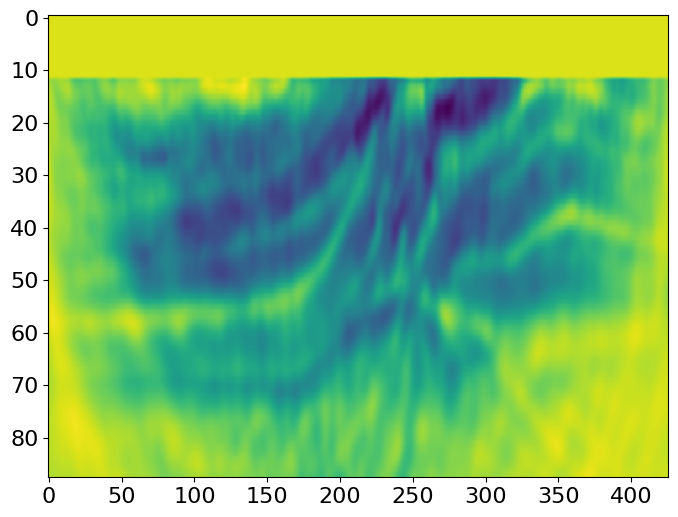

In [43]:
plt.imshow(grad.reshape(-1, shape[1]).T,aspect='auto')
plt.show()

In [44]:
# NBVAL_IGNORE_OUTPUT

start_time = time.time()
# Optimization loop
while (flag != 2 and flag != 4):
    flag = sotb.LBFGS(n, X, fcost, grad, flag, lb, ub)
#     if opt_meth == 'PSTD':
#         flag = sotb.PSTD(n, X, fcost, grad, grad_preco, flag, lb, ub)
#     elif opt_meth == 'PNLCG':
#         flag = sotb.PNLCG(n, X, fcost, grad, grad_preco, flag, lb, ub)
#     elif opt_meth == 'LBFGS':
#         flag = sotb.LBFGS(n, X, fcost, grad, flag, lb, ub)
#     else:
#         msg_strng = "{} method is not valid; it must be one of the following:"
#         raise ValueError(msg_strng.format(opt_meth, ", PSTD, PNLCG or LBFGS"))
    if (flag == 1):
        # compute cost and gradient at point x
        fcost, grad = gen_grd_in_cluster(grd_object_future, break_list, my_function, X)
        # no preconditioning in this test: simply copy grad in
        # grad_preco
        if opt_meth != 'LBFGS':
            grad_preco = np.copy(grad)
elapsed_time = time.time() - start_time
time_format = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("Iterative inversion took :- {}".format(time_format))

# Helpful console writings
print('END OF TEST')
print('FINAL iterate is : ', X)
if opt_meth == 'LBFGS':
    print('See the convergence history in iterate_'+opt_meth[:2]+'.dat')
    s = 'vp_final_result_'+opt_meth[:2]
# elif opt_meth == 'PNLCG':
#     print('See the convergence history in iterate_'+opt_meth[3:]+'.dat')
#     s = 'vp_final_result_'+opt_meth[3:]
# else:
#     print('See the convergence history in iterate_'+opt_meth[1:-1]+'.dat')
#     s = 'vp_final_result_'+opt_meth[1:-1]

# Save final model/image

X = 1./np.sqrt(X)
g = open(results_path+s+'.file', 'wb')
X.reshape(-1, shape[1]).astype('float32').tofile(g)
with h5py.File(results_path+s+'.h5', 'w') as f:
    f.create_dataset('vp', data=X.reshape(-1, shape[1]).astype('float32'))
    f.create_dataset('metadata', data=json.dumps(metadata))

Operator `Forward` ran in 2.18 s
Operator `Gradient` ran in 4.56 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:28:02,753 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.69 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:02,762 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.72 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:02,788 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distribut

2023-10-03 12:28:05,219 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:05,261 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.20 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:05,345 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:05,361 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:05,473 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:05,493 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker mem

Cost_fcn eval took    39.28 sec - Cost_fcn= 1.646E+08


Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.53 s
Operator `Forward` ran in 2.88 s
Operator `Forward` ran in 3.22 s
Operator `Forward` ran in 3.24 s
Operator `Gradient` ran in 7.78 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.26 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:28:45,475 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:28:45,786 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 

Operator `Gradient` ran in 8.31 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.48 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.65 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.55 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    32.82 sec - Cost_fcn= 1.658E+08


Operator `Forward` ran in 1.97 s
Operator `Gradient` ran in 4.32 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:29:19,423 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.70 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:29:19,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:29:20,121 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distribut

2023-10-03 12:29:23,897 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:29:24,174 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.71 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:29:24,264 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:29:25,165 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

Cost_fcn eval took    43.27 sec - Cost_fcn= 1.654E+08


Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.23 s
2023-10-03 12:29:55,281 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.99 s
Operator `Forward` ran in 2.80 s
Operator `Gradient` ran in 7.40 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.17 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.06 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:30:01,721 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for mor

Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 1.84 s
Operator `Forward` ran in 2.48 s
Operator `Forward` ran in 3.43 s
Operator `Forward` ran in 4.12 s
Operator `Gradient` ran in 8.95 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.38 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 5.63 s
Operator `Forward` ran in 5.11 s
Operator `Gradient` ran in 9.18 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.33 s
Operator `Gradient` ran in 9.25 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.56 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.92 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.94 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.34 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.30 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.00 s
Operator `Pointwise` ran in 0.01 s
Operator `Gra

Cost_fcn eval took    33.89 sec - Cost_fcn= 1.638E+08


Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.24 s
2023-10-03 12:30:27,776 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.46 s
Operator `Forward` ran in 2.41 s
Operator `Gradient` ran in 6.37 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.38 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:30:34,423 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.18 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:30:34,816 - distributed.worker.memory - WARNING - Worker is at 27% memory usage. Resuming worker. Process memory: 1.03 GiB -

Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 1.93 s
Operator `Forward` ran in 1.58 s
2023-10-03 12:30:41,901 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.08 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:30:41,976 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.14 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 3.80 s
Operator `Forward` ran in 4.37 s
Operator `Forward` ran in 4.55 s
Operator `Forward` ran in 4.23 s
Operator `Forward` ran in 5.69 s
Operator `Forward` ran in 5.54 s
Operator `Forward` ran in 6.08 s
Operator `Forward` ran in 5.54 s
Operator `Gradient` ran in 11.19 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 11.92 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 12.00 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 13.14 s
Operator `Pointwise

Cost_fcn eval took    36.93 sec - Cost_fcn= 1.573E+08


Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.19 s
Operator `Gradient` ran in 5.30 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.20 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:31:12,494 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.67 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:13,464 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:13,496 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:13,670 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may 

2023-10-03 12:31:17,264 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:17,328 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:17,331 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.14 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:17,376 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:17,681 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:31:17,772 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker mem

Cost_fcn eval took    40.68 sec - Cost_fcn= 1.828E+08


Operator `Forward` ran in 1.83 s
Operator `Forward` ran in 2.06 s
2023-10-03 12:31:45,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.60 s
Operator `Forward` ran in 2.52 s
Operator `Forward` ran in 3.11 s
Operator `Gradient` ran in 7.09 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:31:51,185 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 7.17 s
Operator `Pointwise` ran i

Operator `Gradient` ran in 8.53 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 3.87 s
Operator `Forward` ran in 4.63 s
Operator `Forward` ran in 4.39 s
Operator `Gradient` ran in 8.63 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.63 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.40 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.69 s
Operator `Gradient` ran in 9.09 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.16 s
Operator `Gradient` ran in 8.79 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.01 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.01 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.18 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 4.03 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 3.94 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    33.08 sec - Cost_fcn= 1.360E+08


Operator `Forward` ran in 1.89 s
Operator `Gradient` ran in 4.49 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:32:27,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:32:27,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.66 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:32:27,494 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distribut

2023-10-03 12:32:32,324 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.69 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:32:32,559 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 2.77 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:32:32,717 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:32:32,753 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.52 s
Operator `Forward` ran in 2.43 s
2023-10-03 12:32:33,817 - distributed.worker.memory - WARNING - gc.coll

Cost_fcn eval took    43.89 sec - Cost_fcn= 8.936E+07


Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 3.31 s
Operator `Forward` ran in 2.99 s
Operator `Forward` ran in 3.33 s
Operator `Forward` ran in 3.66 s
Operator `Gradient` ran in 8.32 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.47 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:33:09,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 8.85 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:33:11,155 - distributed.worker.memory - WARNING - gc.collect() took 1.121s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smalle

Cost_fcn eval took    31.11 sec - Cost_fcn= 3.252E+07


Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.41 s
Operator `Gradient` ran in 5.78 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.79 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.66 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:33:41,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:33:41,850 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:33:42,906 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
2

2023-10-03 12:33:48,083 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:33:48,161 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:33:48,180 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:33:48,231 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.48 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.65 s
Operator `Forward` ran in 3.71 s
Operator `Forward` ran in 4.90 s
Operator `Forward` ran in 5.37 s
Operator `Forward` ran in 5.86 s
Operator `Forward` ran in 5.48 s
Operator `Gradient` ran

Cost_fcn eval took    39.29 sec - Cost_fcn= 3.243E+07


Operator `Forward` ran in 1.87 s
2023-10-03 12:34:11,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.03 s
Operator `Gradient` ran in 5.10 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:34:16,118 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:34:16,317 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit

2023-10-03 12:34:28,742 - distributed.worker.memory - WARNING - gc.collect() took 1.063s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:34:28,743 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:34:28,833 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:34:28,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:34:29,073 - distributed.worker.memory - WARNING - Unmanaged memo

Cost_fcn eval took    40.04 sec - Cost_fcn= 3.156E+07


Operator `Forward` ran in 1.78 s
Operator `Gradient` ran in 4.48 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:35:00,231 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.66 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:00,866 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.68 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:01,240 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:01,34

2023-10-03 12:35:04,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.68 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:04,773 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.08 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:04,893 - distributed.worker.memory - WARNING - Worker is at 71% memory usage. Resuming worker. Process memory: 2.67 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:04,986 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 2.90 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:05,181 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB 

Cost_fcn eval took    42.58 sec - Cost_fcn= 2.391E+07


Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.09 s
2023-10-03 12:35:35,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.59 s
2023-10-03 12:35:39,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 5.93 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:35:39,953 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory

2023-10-03 12:35:47,299 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.04 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:47,371 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:47,375 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.03 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:35:47,493 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.86 s
Operator `Forward` ran in 2.76 s
Operator `Forward` ran in 4.64 s
Operator `Forward` ran in 4.36 s
Operator `Gradient` ran in 8.54 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.68 s
Operator `Forward` ran in 4.50 s
Operator `Forward` ran in 5.43 s
Operator `Gradient` 

Cost_fcn eval took    36.76 sec - Cost_fcn= 1.506E+07


Operator `Forward` ran in 2.50 s
Operator `Forward` ran in 2.09 s
2023-10-03 12:36:11,371 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.46 s
2023-10-03 12:36:14,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 3.21 s
2023-10-03 12:36:14,778 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to

Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 1.58 s
Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.74 s
Operator `Forward` ran in 2.89 s
Operator `Forward` ran in 4.40 s
Operator `Gradient` ran in 8.58 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.24 s
Operator `Forward` ran in 5.25 s
Operator `Forward` ran in 4.84 s
Operator `Gradient` ran in 9.87 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.65 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 11.15 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 10.30 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.88 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.75 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.80 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.67 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.34 s
Operator `Poi

Cost_fcn eval took    33.72 sec - Cost_fcn= 1.422E+07


Operator `Forward` ran in 1.79 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.80 s
Operator `Forward` ran in 2.81 s
Operator `Forward` ran in 3.23 s
Operator `Gradient` ran in 6.81 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.08 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:36:53,923 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.67 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:36:55,105 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:36:55,137 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming w

Operator `Forward` ran in 2.44 s
Operator `Forward` ran in 2.61 s
Operator `Forward` ran in 2.92 s
Operator `Forward` ran in 3.70 s
Operator `Forward` ran in 4.73 s
Operator `Forward` ran in 5.01 s
Operator `Gradient` ran in 9.81 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 5.85 s
Operator `Forward` ran in 4.76 s
Operator `Gradient` ran in 10.24 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 10.42 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 11.66 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 10.61 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 11.37 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.78 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.65 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.86 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.49 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.76 s
Operato

Cost_fcn eval took    35.27 sec - Cost_fcn= 1.089E+07


Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.12 s
2023-10-03 12:37:21,988 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:22,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:22,517 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.

2023-10-03 12:37:34,044 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.06 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:34,074 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:34,525 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:34,548 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:34,723 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.06 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:37:34,763 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker mem

Cost_fcn eval took    42.28 sec - Cost_fcn= 8.707E+06


Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.30 s
Operator `Gradient` ran in 5.95 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.91 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.78 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:38:11,293 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:11,859 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limi

2023-10-03 12:38:15,926 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:15,945 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:15,954 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:16,429 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:16,518 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 1.87 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 3.45 s
Operator `Forward`

Cost_fcn eval took    39.35 sec - Cost_fcn= 7.264E+06


Operator `Forward` ran in 2.90 s
Operator `Forward` ran in 2.76 s
Operator `Forward` ran in 2.69 s
2023-10-03 12:38:44,598 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.66 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:44,993 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:46,792 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 2.79 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.31 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.14 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.18 s
Operator `Pointwise` ran in 0.01 s
2

2023-10-03 12:38:54,418 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.04 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:54,467 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:54,522 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:38:54,601 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.15 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 3.83 s
Operator `Forward` ran in 3.54 s
Operator `Gradient` ran in 7.46 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 3.62 s
Operator `Forward` ran in 4.54 s
Operator `Forward` ran in 5.09 s
Operator `Forward` ran in 5.20 s
Operator `Forward` ran in 5.45 s
Operator `Forward` r

Cost_fcn eval took    39.02 sec - Cost_fcn= 6.444E+06


Operator `Forward` ran in 2.87 s
Operator `Forward` ran in 3.20 s
Operator `Forward` ran in 3.37 s
Operator `Forward` ran in 4.23 s
Operator `Forward` ran in 4.51 s
Operator `Forward` ran in 4.01 s
Operator `Forward` ran in 3.47 s
2023-10-03 12:39:30,924 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.66 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 10.14 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.59 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:39:32,296 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more 

Cost_fcn eval took    34.81 sec - Cost_fcn= 5.921E+06


Operator `Forward` ran in 1.94 s
Operator `Gradient` ran in 4.87 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:40:04,587 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:04,986 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:05,458 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:05,46

2023-10-03 12:40:08,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:09,023 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:09,293 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:09,663 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:40:09,787 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.16 GiB 

Cost_fcn eval took    43.49 sec - Cost_fcn= 5.526E+06


2023-10-03 12:40:35,623 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.69 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.54 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 3.21 s
2023-10-03 12:40:42,431 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 3.56 s
2023-10-03 12:40:43,551 - distributed.worker.memory - WARNING - gc.collect() took 1.341s. This is usually a sign that some tasks handle too many Python objects at

Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.89 s
Operator `Gradient` ran in 7.33 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.04 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 3.30 s
Operator `Forward` ran in 3.14 s
Operator `Forward` ran in 3.01 s
Operator `Gradient` ran in 7.69 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.58 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.12 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.84 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 4.85 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.04 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 4.18 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    34.50 sec - Cost_fcn= 4.891E+06


Operator `Forward` ran in 2.36 s
Operator `Gradient` ran in 4.31 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:41:17,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:18,110 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:18,221 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distribut

2023-10-03 12:41:27,953 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:28,488 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.09 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:28,583 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:28,866 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.04 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:28,883 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.16 GiB 

Cost_fcn eval took    43.95 sec - Cost_fcn= 4.493E+06


Operator `Forward` ran in 1.92 s
Operator `Forward` ran in 1.76 s
2023-10-03 12:41:58,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:58,333 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:41:58,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.

2023-10-03 12:42:12,018 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:42:12,065 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.46 s
2023-10-03 12:42:12,496 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:42:12,542 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:42:12,622 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.04 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:42:12,667 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Proce

Cost_fcn eval took    41.04 sec - Cost_fcn= 4.110E+06


Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 1.88 s
2023-10-03 12:42:39,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.74 s
Operator `Forward` ran in 2.92 s
2023-10-03 12:42:43,158 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 7.30 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.04 s
2023-10-03 12:42:45,342 - d

Operator `Gradient` ran in 7.48 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.98 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.57 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.64 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 4.88 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    30.20 sec - Cost_fcn= 3.879E+06


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.48 s
Operator `Forward` ran in 2.65 s
Operator `Forward` ran in 2.36 s
Operator `Gradient` ran in 6.87 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:43:16,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.81 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:43:16,630 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.76 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:43:17,530 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming w

Cost_fcn eval took    33.48 sec - Cost_fcn= 3.654E+06


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.00 s
2023-10-03 12:43:44,985 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:43:45,927 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 5.91 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.06 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.79 s
Operator `Pointwise` ra

2023-10-03 12:43:56,015 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:43:56,200 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 3.44 s
Operator `Forward` ran in 3.79 s
Operator `Forward` ran in 4.17 s
Operator `Gradient` ran in 8.19 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 5.00 s
Operator `Forward` ran in 5.49 s
Operator `Forward` ran in 5.51 s
Operator `Gradient` ran in 10.58 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 4.87 s
Operator `Forward` ran in 5.86 s
Operator `Forward` ran in 6.39 s
Operator `Gradient` ran in 11.76 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 13.28 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient

Cost_fcn eval took    37.19 sec - Cost_fcn= 3.564E+06


Operator `Forward` ran in 1.74 s
2023-10-03 12:44:20,886 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:21,190 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 4.65 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:44:25,276 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:25,42

2023-10-03 12:44:33,573 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:33,583 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:33,593 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:33,678 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:44:33,742 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.75 s
Operator `Forward` ran in 2.81 s
Operator `Forward` ran in 2.59 s
Operator `Forward` ran in 2.67 s
Operator `Forward`

Cost_fcn eval took    41.33 sec - Cost_fcn= 3.510E+06


Operator `Forward` ran in 1.54 s
2023-10-03 12:45:00,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.44 s
Operator `Forward` ran in 2.60 s
Operator `Forward` ran in 3.30 s
Operator `Gradient` ran in 6.46 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:45:06,585 - distributed.worker.memory - WARNING - gc.collect() took 1.522s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:45:06,585 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://d

Operator `Gradient` ran in 7.67 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.96 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 1.86 s
Operator `Gradient` ran in 7.11 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.63 s
Operator `Forward` ran in 3.31 s
Operator `Forward` ran in 4.32 s
Operator `Forward` ran in 3.45 s
Operator `Gradient` ran in 8.22 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.72 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.67 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.52 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.56 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.49 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.18 s
Operator `Pointwise` ran in 0.01 s
Operator `Gra

Cost_fcn eval took    30.15 sec - Cost_fcn= 3.373E+06


Operator `Forward` ran in 2.58 s
Operator `Forward` ran in 2.52 s
Operator `Forward` ran in 2.66 s
Operator `Forward` ran in 2.30 s
2023-10-03 12:45:33,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 6.56 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.69 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.88 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.42 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:45:39,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory

Operator `Gradient` ran in 8.81 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.56 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.08 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.31 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.44 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    36.03 sec - Cost_fcn= 3.348E+06


2023-10-03 12:46:05,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 1.86 s
2023-10-03 12:46:08,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 3.38 s
Operator `Forward` ran in 3.23 s
2023-10-03 12:46:13,043 - distributed.worker.memory - WARNING - gc.collect() took 1.538s. This is usually a sign that some tasks 

Operator `Forward` ran in 4.02 s
Operator `Forward` ran in 3.86 s
Operator `Forward` ran in 4.40 s
Operator `Forward` ran in 4.86 s
Operator `Gradient` ran in 9.36 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 10.93 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 10.20 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.98 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.51 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 9.14 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.15 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.55 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.25 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.46 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    32.67 sec - Cost_fcn= 3.308E+06


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.37 s
2023-10-03 12:46:41,623 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:46:43,024 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 4.79 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 4.49 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:46:44,215 - distributed.worker.memory - WARNING - Unmanaged memory use is hi

2023-10-03 12:46:54,987 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.97 s
Operator `Forward` ran in 2.61 s
Operator `Forward` ran in 4.48 s
Operator `Forward` ran in 4.59 s
Operator `Forward` ran in 5.82 s
Operator `Forward` ran in 5.15 s
Operator `Forward` ran in 5.63 s
Operator `Forward` ran in 6.19 s
Operator `Forward` ran in 6.34 s
Operator `Forward` ran in 6.54 s
Operator `Forward` ran in 6.74 s
Operator `Forward` ran in 6.95 s
Operator `Forward` ran in 7.18 s
Operator `Gradient` ran in 14.96 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 15.90 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 15.80 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 14.70 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 14.34 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient

Cost_fcn eval took    42.81 sec - Cost_fcn= 3.241E+06


Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.57 s
Operator `Forward` ran in 2.58 s
Operator `Forward` ran in 2.76 s
Operator `Gradient` ran in 7.15 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:47:29,372 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 7.10 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:47:30,695 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:47:30,798 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023

2023-10-03 12:47:38,021 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:47:38,043 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.84 s
Operator `Forward` ran in 1.69 s
Operator `Gradient` ran in 5.69 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 2.99 s
Operator `Gradient` ran in 6.45 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 3.95 s
Operator `Forward` ran in 3.58 s
Operator `Forward` ran in 3.76 s
Operator `Forward` ran in 3.40 s
Operator `Gradient` ran in 8.62 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 3.77 s
Operator `Gradient` ran in 9.18 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.93 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 7.90 s
Operator `Pointwi

Cost_fcn eval took    33.50 sec - Cost_fcn= 3.163E+06


Operator `Forward` ran in 1.63 s
2023-10-03 12:47:58,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 4.42 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:48:00,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:04,577 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:04,77

2023-10-03 12:48:09,392 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:09,574 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:10,056 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:10,088 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:10,249 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:10,264 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker mem

Cost_fcn eval took    42.74 sec - Cost_fcn= 3.138E+06


Operator `Forward` ran in 2.35 s
2023-10-03 12:48:38,650 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:48:38,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.85 s
2023-10-03 12:48:39,237 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.

2023-10-03 12:48:54,613 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.25 s
Operator `Gradient` ran in 5.41 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 2.51 s
Operator `Forward` ran in 2.56 s
Operator `Gradient` ran in 6.92 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.28 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.90 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.41 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 6.19 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.87 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 5.19 s
Operator `Pointwise` ran in 0.01 s


Cost_fcn eval took    30.81 sec - Cost_fcn= 4.535E+06


Operator `Forward` ran in 1.83 s
2023-10-03 12:49:12,414 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 4.04 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:49:18,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.69 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:49:18,370 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distribut

2023-10-03 12:49:23,136 - distributed.worker.memory - WARNING - gc.collect() took 1.004s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:49:23,136 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:49:23,230 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.08 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:49:23,722 - distributed.worker.memory - WARNING - gc.collect() took 1.094s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:49:23,725 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.07 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:49:23,795 - distri

Cost_fcn eval took    41.52 sec - Cost_fcn= 3.481E+06


2023-10-03 12:49:50,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.48 s
2023-10-03 12:49:50,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.47 s
2023-10-03 12:49:51,716 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.

2023-10-03 12:50:03,993 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.67 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:50:04,059 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.68 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:50:04,293 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.59 s
/home/atila/.conda/envs/devitin/lib/python3.9/site-package

Cost_fcn eval took    32.46 sec - Cost_fcn= 3.219E+06


Operator `Forward` ran in 1.95 s
2023-10-03 12:50:26,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
Operator `Gradient` ran in 4.45 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:50:31,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:50:32,322 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.03 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:50:32,94

Operator `Forward` ran in 2.41 s
Operator `Forward` ran in 2.73 s
Operator `Forward` ran in 3.77 s
Operator `Forward` ran in 4.52 s
Operator `Forward` ran in 5.10 s
Operator `Forward` ran in 5.18 s
Operator `Forward` ran in 5.27 s
Operator `Forward` ran in 5.80 s
Operator `Gradient` ran in 10.63 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 6.43 s
Operator `Forward` ran in 6.55 s
Operator `Forward` ran in 6.56 s
Operator `Forward` ran in 6.69 s
Operator `Gradient` ran in 14.38 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 7.09 s
Operator `Gradient` ran in 15.18 s
Operator `Pointwise` ran in 0.01 s
Operator `Forward` ran in 7.34 s
Operator `Gradient` ran in 13.23 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 16.48 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 12.98 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 14.56 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 13.13 s
Operator `Poi

Cost_fcn eval took    42.68 sec - Cost_fcn= 1.469E+08


Operator `Forward` ran in 1.58 s
Operator `Forward` ran in 2.20 s
2023-10-03 12:51:07,780 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:08,869 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:09,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.

2023-10-03 12:51:21,682 - distributed.worker.memory - WARNING - gc.collect() took 1.294s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:51:21,682 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.03 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:21,766 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:21,968 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.68 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:22,269 - distributed.worker.memory - WARNING - Worker is at 8

Cost_fcn eval took    38.00 sec - Cost_fcn= 1.469E+08


2023-10-03 12:51:40,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:40,829 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.67 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.23 s
2023-10-03 12:51:43,795 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 2.54 s
2023-10-03 12:51:44,178 - distributed.worker.memory - WARN

Operator `Forward` ran in 1.77 s
Operator `Gradient` ran in 5.16 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:51:58,772 - distributed.worker.memory - WARNING - gc.collect() took 1.087s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:51:58,774 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:58,821 - distributed.worker.memory - WARNING - gc.collect() took 1.085s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:51:58,823 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.04 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:51:58,864 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resum

Cost_fcn eval took    31.64 sec - Cost_fcn= 1.469E+08


Operator `Forward` ran in 2.46 s
Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.41 s
2023-10-03 12:52:17,650 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:17,899 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:18,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.

2023-10-03 12:52:28,986 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:29,176 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:29,336 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.07 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:29,396 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:29,561 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.03 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:29,570 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.17 GiB -- Worker mem

Cost_fcn eval took    38.80 sec - Cost_fcn= 1.469E+08


2023-10-03 12:52:51,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.64 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:52:51,633 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.65 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.28 s
2023-10-03 12:52:54,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.

2023-10-03 12:53:08,080 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:08,084 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.20 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:08,097 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.86 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.85 s
Operator `Forward` ran in 3.41 s
Operator `Forward` ran in 3.45 s
Operator `Forward` ran in 3.64 s
Operator `Gradient` ran in 7.85 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.74 s
Operator `Pointwise` ran in 0.01 s
Operator `Gradient` ran in 8.74 s
Operator `Pointwise` 

Cost_fcn eval took    31.21 sec - Cost_fcn= 1.469E+08


Operator `Forward` ran in 1.72 s
2023-10-03 12:53:28,681 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:28,991 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.62 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:28,991 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-

2023-10-03 12:53:39,186 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.02 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:39,189 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:39,269 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:39,271 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.66 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:53:39,278 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB 

Cost_fcn eval took    45.81 sec - Cost_fcn= 1.470E+08


Operator `Forward` ran in 1.56 s
Operator `Gradient` ran in 4.09 s
Operator `Pointwise` ran in 0.01 s
2023-10-03 12:54:19,970 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.67 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:20,064 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.70 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:21,105 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:21,19

Operator `Forward` ran in 2.59 s
2023-10-03 12:54:25,788 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:25,832 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:25,909 - distributed.worker.memory - WARNING - gc.collect() took 1.038s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-10-03 12:54:25,910 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.00 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:25,959 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
2023-10-03 12:54:26,135 - distributed.worker.memory - WARN

Cost_fcn eval took    41.67 sec - Cost_fcn= 1.376E+08
Iterative inversion took :- 00:26:55
END OF TEST
FINAL iterate is :  [0.44444445 0.44444445 0.44444445 ... 0.07567548 0.07503678 0.07541855]
See the convergence history in iterate_LB.dat


Operator `Gradient` ran in 7.61 s
Operator `Pointwise` ran in 0.01 s


Ensure that all resources are properly released

In [45]:
client.close() # releases all resources held by the client and shuts down all workers
cluster.close() # shuts down the cluster itself

Visualize velocity model and objective function

Operator `initdamp` ran in 0.01 s


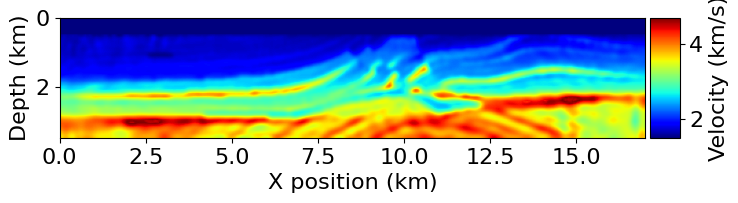

In [46]:
# NBVAL_IGNORE_OUTPUT

model = Model(vp=X.reshape(-1, shape[1]).astype('float32'), origin=origin, shape=shape, spacing=spacing,
              space_order=4, nbl=50)
plot_velocity(model)
X.reshape(-1, shape[1]).astype('float32').tofile("final_result_beta.bin")

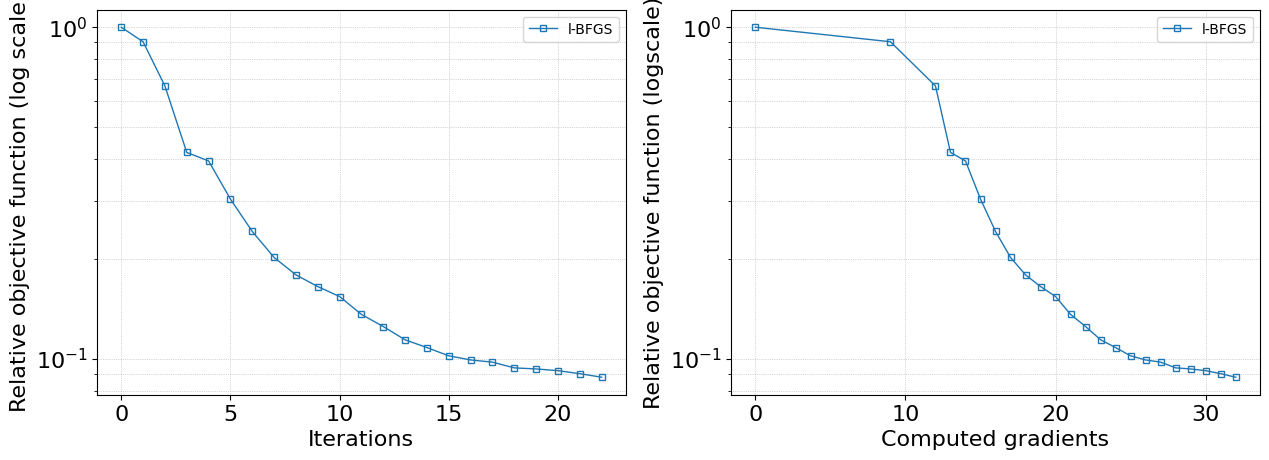

In [47]:
# NBVAL_IGNORE_OUTPUT

d, d2 = read_log_files(words)
make_a_plot(d, d2, lconfg)

In [48]:
# NBVAL_IGNORE_OUTPUT

SafeExtern("rm -rf *.segy *.h5 *.pickle", "./") # remove local files

<ipykernel.iostream.OutStream object at 0x7fee4932ae80> Child returned 0


0